In [ ]:
import pandas as pd

df = pd.read_csv('/content/df_final_with_engineered_features_v1.csv')
df

,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,AMT_CREDIT,INST_AMT_PAYMENT_MEAN,BUREAU_DAYS_CREDIT_MAX,DAYS_EMPLOYED,...,BUREAU_CREDIT_RECENT,SHORT_CREDIT_HISTORY,POS_DPD_MEAN_LOG,HAS_DPD_FLAG,BUREAU_ACTIVE_DEBT_MEAN_LOG,BUREAU_DEBT_RATIO,HIGH_BUREAU_LEVERAGE,PAYMENT_RATIO_MEAN,PREV_REFUSAL_RATE,TARGET
0,Business Entity Type 3,0.083037,0.262949,0.139376,-9461.0,24700.5,406597.5,11559.247105,-103.0,-637.0,...,103.0,0,0.000000,0,10.332787,0.284121,0,0.999913,0.000000,1.0
1,School,0.311267,0.622246,0.535276,-16765.0,35698.5,1293502.5,64754.586000,-606.0,-1188.0,...,606.0,0,0.000000,0,0.000000,0.000000,0,0.999985,0.000000,0.0
2,Government,0.505998,0.555912,0.729567,-19046.0,6750.0,135000.0,7096.155000,-408.0,-225.0,...,408.0,0,0.000000,0,0.000000,0.000000,0,0.999859,0.000000,0.0
3,Business Entity Type 3,0.505998,0.650442,0.535276,-19005.0,29686.5,312682.5,62947.088438,-300.0,-3039.0,...,300.0,0,0.000000,0,10.462518,0.175750,0,0.999984,0.142857,0.0
4,Religion,0.505998,0.322738,0.535276,-19932.0,21865.5,513000.0,12214.060227,-1149.0,-3038.0,...,1149.0,0,0.000000,0,0.000000,0.000000,0,0.964209,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Services,0.145570,0.681632,0.535276,-9327.0,27558.0,254700.0,7492.924286,-300.0,-236.0,...,300.0,0,0.000000,0,10.462518,0.175750,0,0.999867,0.000000,0.0
307507,XNA,0.505998,0.115992,0.535276,-20775.0,12001.5,269550.0,10069.867500,-300.0,365243.0,...,300.0,0,0.000000,0,10.462518,0.175750,0,0.999901,0.000000,0.0
307508,School,0.744026,0.535722,0.218859,-14966.0,29979.0,677664.0,4115.915357,-713.0,-7921.0,...,713.0,0,0.257829,1,13.014687,0.453493,0,0.935285,0.000000,0.0
307509,Business Entity Type 1,0.505998,0.514163,0.661024,-11961.0,20205.0,370107.0,10239.832895,-1104.0,-4786.0,...,1104.0,0,0.000000,0,0.000000,0.000000,0,0.999902,0.000000,1.0


In [ ]:
# Identificar colunas categóricas
# Importância: garante que apenas colunas object sejam transformadas
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(cat_cols)

['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'CODE_GENDER', 'AGE_BIN', 'DEBT_BIN', 'INCOME_BIN']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Criar cópia do dataframe
# Importância: evita modificar a base original
df_encoded = df.copy()

# Codificar variáveis categóricas
# Importância: LightGBM exige valores numéricos
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

In [ ]:
# Separar features e target
X = df_encoded.drop(columns=['TARGET'])
y = df_encoded['TARGET']


In [ ]:
from sklearn.model_selection import train_test_split

# Split estratificado
# Importância: mantém proporção de inadimplentes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
import lightgbm as lgb

# Dataset LightGBM
# Importância: formato otimizado para treino eficiente
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [ ]:
# Parâmetros do LightGBM
# Importância: equilíbrio entre performance e generalização
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

In [ ]:
# Treinar modelo
# Importância: aprender padrões de inadimplência
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
)

In [ ]:
from sklearn.metrics import roc_auc_score

# Prever probabilidades
# Importância: avaliação baseada em score de risco
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# Calcular AUC
# Importância: métrica padrão em crédito
auc = roc_auc_score(y_val, y_val_pred)
print(f'AUC validação: {auc:.4f}')


AUC validação: 0.7759


## **- SHAP**

In [ ]:
import shap

# Criar explainer específico para modelos baseados em árvores
# TreeExplainer é rápido, preciso e ideal para LightGBM
explainer = shap.TreeExplainer(model)

In [ ]:
# Calcular valores SHAP
# Quantifica quanto cada feature contribui para o score de risco
shap_values = explainer(X)

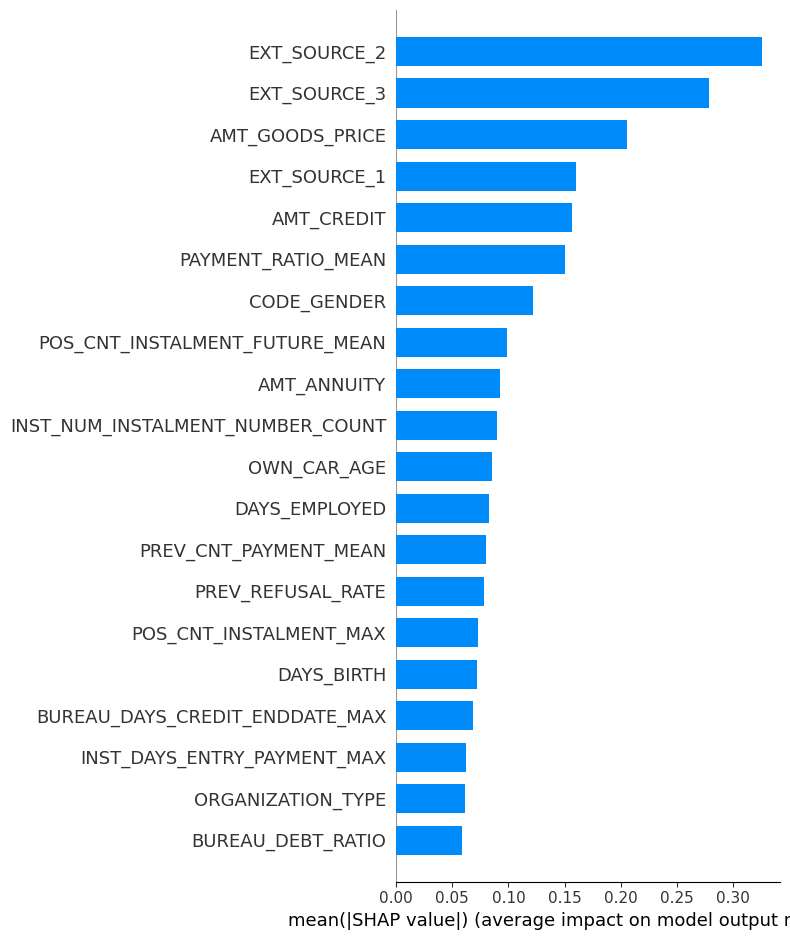

In [ ]:
# Summary plot SHAP
# Importância: visão global das features mais relevantes
shap.summary_plot(shap_values.values, X, plot_type="bar", max_display=20)

# **Seleção de features**

- Foi priorizados features com grande poder informativo e eliminados features que apresentam redundâncias com outras, de acordo com as 13 features mais representativas exemplificadas utilizando SHAP

In [ ]:
# Features escolhidas para o dataset final v2
FEATURES_V2 = [
    # Fontes externas (núcleo do modelo)
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',

    # Crédito e capacidade de pagamento
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'PAYMENT_RATIO_MEAN',

    # Parcelamento / comportamento POS
    'POS_CNT_INSTALMENT_FUTURE_MEAN',
    'INST_NUM_INSTALMENT_NUMBER_COUNT',

    # Histórico de crédito anterior
    'PREV_CNT_PAYMENT_MEAN',
    'PREV_REFUSAL_RATE',

    # Estabilidade socioeconômica
    'DAYS_EMPLOYED',
    'OWN_CAR_AGE',

    # Perfil Demográfico
    'CODE_GENDER'
]

In [ ]:
# Garantir que só usamos colunas existentes
features_v2 = [f for f in FEATURES_V2 if f in df.columns]

# Criar dataset final
df_v2 = df[features_v2 + ['TARGET']].copy()

df_v2.columns

Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT',
       'AMT_ANNUITY', 'PAYMENT_RATIO_MEAN', 'POS_CNT_INSTALMENT_FUTURE_MEAN',
       'INST_NUM_INSTALMENT_NUMBER_COUNT', 'PREV_CNT_PAYMENT_MEAN',
       'PREV_REFUSAL_RATE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'CODE_GENDER',
       'TARGET'],
      dtype='object')

In [ ]:
# Salva do dataset final com as melhores features
df_v2.to_csv('df_final_features2.csv', index=False)

In [ ]:
import pandas as pd

df_v2 = pd.read_csv('/content/df_final_features2.csv')
df_v2

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_CREDIT,AMT_ANNUITY,PAYMENT_RATIO_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,INST_NUM_INSTALMENT_NUMBER_COUNT,PREV_CNT_PAYMENT_MEAN,PREV_REFUSAL_RATE,DAYS_EMPLOYED,OWN_CAR_AGE,CODE_GENDER,TARGET
0,0.083037,0.262949,0.139376,406597.5,24700.5,0.999913,15.000000,19.0,24.000000,0.000000,-637.0,9.0,M,1.0
1,0.311267,0.622246,0.535276,1293502.5,35698.5,0.999985,5.785714,25.0,10.000000,0.000000,-1188.0,9.0,F,0.0
2,0.505998,0.555912,0.729567,135000.0,6750.0,0.999859,2.250000,3.0,4.000000,0.000000,-225.0,26.0,M,0.0
3,0.505998,0.650442,0.535276,312682.5,29686.5,0.999984,8.238095,16.0,23.000000,0.142857,-3039.0,9.0,F,0.0
4,0.505998,0.322738,0.535276,513000.0,21865.5,0.964209,8.969697,66.0,20.666667,0.000000,-3038.0,9.0,M,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.145570,0.681632,0.535276,254700.0,27558.0,0.999867,3.888889,7.0,8.000000,0.000000,-236.0,9.0,M,0.0
307507,0.505998,0.115992,0.535276,269550.0,12001.5,0.999901,3.000000,6.0,6.000000,0.000000,365243.0,9.0,F,0.0
307508,0.744026,0.535722,0.218859,677664.0,29979.0,0.935285,2.000000,14.0,5.000000,0.000000,-7921.0,9.0,F,0.0
307509,0.505998,0.514163,0.661024,370107.0,20205.0,0.999902,10.350000,19.0,15.000000,0.000000,-4786.0,9.0,F,1.0


In [ ]:
# Identificar colunas categóricas
# Importância: garante que apenas colunas object sejam transformadas
cat_cols = df_v2.select_dtypes(include='object').columns.tolist()
print(cat_cols)

['CODE_GENDER']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Criar cópia do dataframe
# Importância: evita modificar a base original
df_encoded2 = df_v2.copy()

# Codificar variáveis categóricas
# Importância: LightGBM exige valores numéricos
for col in cat_cols:
    le = LabelEncoder()
    df_encoded2[col] = le.fit_transform(df_encoded2[col].astype(str))

In [ ]:
# Separar features e target
X_2 = df_encoded2.drop(columns=['TARGET'])
y_2 = df_encoded2['TARGET']

In [ ]:
from sklearn.model_selection import train_test_split

# Split estratificado
# Importância: mantém proporção de inadimplentes
X_2_train, X_2_val, y_2_train, y_2_val = train_test_split(X_2, y_2, test_size=0.2, stratify=y_2, random_state=42)

In [ ]:
import lightgbm as lgb

# Dataset LightGBM
# Importância: formato otimizado para treino eficiente
train_data2 = lgb.Dataset(X_2_train, label=y_2_train)
val_data2 = lgb.Dataset(X_2_val, label=y_2_val, reference=train_data2)

In [ ]:
# Parâmetros do LightGBM
# Importância: equilíbrio entre performance e generalização
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

In [ ]:
# Treinar modelo
# Importância: aprender padrões de inadimplência
model2 = lgb.train(
    params,
    train_data2,
    valid_sets=[train_data2, val_data2],
    valid_names=['train2', 'valid2'],
    num_boost_round=1000,
)

In [ ]:
from sklearn.metrics import roc_auc_score

# Prever probabilidades
# Importância: avaliação baseada em score de risco
y_val_pred2 = model2.predict(X_2_val, num_iteration=model2.best_iteration)

# Calcular AUC
# Importância: métrica padrão em crédito
auc = roc_auc_score(y_2_val, y_val_pred2)
print(f'AUC validação: {auc:.4f}')

AUC validação: 0.7557


O segundo modelo apresentou AUC ligeiramente menor, porém mostrou maior estabilidade e menor dependência de features redundantes, o que é preferível para produção em risco de crédito

In [ ]:
# Cálcula KS (mede a separação de bons e maus)

from sklearn.metrics import roc_curve

# Gera as probabilidades previstas pelo modelo
y_proba = model2.predict(X_2_val)

# Calcula FPR, TPR e thresholds da curva ROC
fpr, tpr, thresholds = roc_curve(y_2_val, y_proba)

# Calcula o KS (diferença máxima entre TPR e FPR)
ks_values = tpr - fpr
ks = ks_values.max()

print(f'KS: {ks:.3f}')


KS: 0.377


O KS entre 0.30 e 0.40 indica que o modelo separa muito bem bons de maus pagadores, indicando que podemos seguir para política de crédito

**- Definição do threshold**

O threshold (limiar de decisão) é o valor que transforma a probabilidade prevista pelo modelo em uma decisão binária. ele basicamente responde a pergunta “A partir de qual probabilidade eu digo que o cliente é inadimplente?”

In [ ]:
import numpy as np
from sklearn.metrics import recall_score

# Definir lista de thresholds a serem testados
thresholds_test = np.arange(0.05, 0.9, 0.01)

recalls = []
for t in thresholds_test:
    y_pred = (y_proba >= t).astype(int)   # Converter probabilidade em classe usando o threshold
    recalls.append(recall_score(y_2_val, y_pred))  # Calcular recall para a classe positiva
recalls = np.array(recalls)

recall_target = 0.85

# Thresholds que atingem o recall alvo
valid_mask = recalls >= recall_target
valid_thresholds = thresholds_test[valid_mask]

if len(valid_thresholds) == 0:
    # Encontrar o recall máximo observado e o threshold correspondente
    max_recall_idx = recalls.argmax()
    max_recall = recalls[max_recall_idx]
    threshold_max_recall = thresholds_test[max_recall_idx]

    print(
        f'Não existe threshold que atinja recall ≥ {recall_target:.0%}. '
        f'Recall máximo observado: {max_recall:.2%} '
        f'(threshold = {threshold_max_recall:.2f})'
    )
else:
    best_threshold = valid_thresholds.max()
    print(
        f'Threshold com recall ≥ {recall_target:.0%}: '
        f'{best_threshold:.2f}'
    )

Não existe threshold que atinja recall ≥ 85%. Recall máximo observado: 82.28% (threshold = 0.05)


Testes mostraram que o recall máximo atingível pelo modelo foi de 82.28%, obtido com threshold de 0.05. Recalls acima desse valor exigiriam thresholds inviáveis operacionalmente

In [ ]:
# Fixa o threshold com recall-alvo = 80% que é mais próximo de 82.28%
recall_target = 0.80
best_threshold = thresholds_test[recalls >= recall_target].max()

print(f'o melhor threshold foi {best_threshold:.2f}')

o melhor threshold foi 0.05


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Converte probabilidades em classes usando o threshold escolhido
y_pred = (y_proba >= best_threshold).astype(int)

print(confusion_matrix(y_2_val, y_pred))
print(classification_report(y_2_val, y_pred))

[[29454 27084]
 [  880  4085]]
              precision    recall  f1-score   support

         0.0       0.97      0.52      0.68     56538
         1.0       0.13      0.82      0.23      4965

    accuracy                           0.55     61503
   macro avg       0.55      0.67      0.45     61503
weighted avg       0.90      0.55      0.64     61503



## **- Tuning de Hiperparâmetros com Optuna**

Fazendo o retreino do modelo com tuning de hiperparâmetros para ver se há um ganho no recall do modelo

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.0 MB/s eta 0:00:00


In [ ]:
import optuna
import lightgbm as lgb
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Cria a função de objetivo do Optuna
def objective(trial):

    # Definição dos hiperparâmetros a serem otimizados pelo Optuna
    params = {
        'objective': 'binary',          # Problema de classificação binária
        'metric': 'auc',                # Métrica de avaliação
        'boosting_type': 'gbdt',         # Gradient Boosting Decision Trees
        'verbosity': -1,                # Silenciar logs do LightGBM

        # Complexidade do modelo
        'num_leaves': trial.suggest_int('num_leaves', 5, 15 ),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),

        # Regularização e generalização
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),

        # Tratamento de desbalanceamento de classes
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 15.0)
    }

    # Validação cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, val_idx in skf.split(X_2_train, y_2_train):
        X_tr, X_val_3 = X_2_train.iloc[train_idx], X_2_train.iloc[val_idx]
        y_tr, y_val_3 = y_2_train.iloc[train_idx], y_2_train.iloc[val_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val_3, label=y_val_3)

        # Treinar modelo LightGBM
        model = lgb.train(
            params,
            dtrain,
            num_boost_round=500,
            valid_sets=[dval]
        )

        # Predição de probabilidades
        y_proba = model.predict(X_val_3)

        # Calcular AUC da dobra
        aucs.append(roc_auc_score(y_val_3, y_proba))

    # Retornar AUC média das dobras
    return np.mean(aucs)


In [ ]:
# Criar estudo do Optuna para maximizar a métrica
study = optuna.create_study(direction='maximize')

# Executar a otimização da função objetivo por 50 tentativas
study.optimize(objective, n_trials=50)

[I 2026-02-01 01:13:52,642] A new study created in memory with name: no-name-ae200bec-1c8d-4b8b-8c70-eac4d2155f0a
[I 2026-02-01 01:14:35,145] Trial 0 finished with value: 0.751749227774698 and parameters: {'num_leaves': 14, 'max_depth': 6, 'learning_rate': 0.04222757192193647, 'n_estimators': 131, 'min_child_samples': 54, 'subsample': 0.8723111815500244, 'colsample_bytree': 0.7656765511698626, 'reg_alpha': 0.03067734596038041, 'reg_lambda': 4.5712578192696345, 'scale_pos_weight': 8.886989387223974}. Best is trial 0 with value: 0.751749227774698.
[I 2026-02-01 01:15:00,006] Trial 1 finished with value: 0.7471981339711512 and parameters: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.022591821719965335, 'n_estimators': 167, 'min_child_samples': 36, 'subsample': 0.9151803142188328, 'colsample_bytree': 0.7239322407700819, 'reg_alpha': 2.939999125621398, 'reg_lambda': 3.98111318462367, 'scale_pos_weight': 7.303082303961655}. Best is trial 0 with value: 0.751749227774698.
[I 2026-02-0

In [ ]:
# Recuperar os melhores hiperparâmetros encontrados pelo Optuna
best_params = study.best_params

# Exibir os hiperparâmetros ótimos
print(best_params)

{'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.09445966348359239, 'n_estimators': 287, 'min_child_samples': 23, 'subsample': 0.6980576391958772, 'colsample_bytree': 0.7280693993357957, 'reg_alpha': 2.6600274786164846, 'reg_lambda': 4.102991242770104, 'scale_pos_weight': 2.9234628877439435}


In [ ]:
# Copia os melhores hiperparâmetros encontrados
final_params = best_params.copy()

# Define parâmetros finais do modelo
final_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': 42
})

# Cria o dataset do LightGBM com dados de treino
dtrain_final = lgb.Dataset(X_2_train, label=y_2_train)

# Treina o modelo final com o número ótimo de iterações
final_model = lgb.train(
    final_params,
    dtrain_final,
    num_boost_round=study.best_trial.user_attrs.get("best_iteration", 500)
)

In [ ]:
# Gera probabilidades de inadimplência no conjunto de validação
y_proba = final_model.predict(X_2_val)

# Define o threshold de decisão
threshold = 0.05
y_pred = (y_proba >= threshold).astype(int) # Converte probabilidades em classes binárias

In [ ]:
# Calcula a matriz de confusão do modelo final
cm = confusion_matrix(y_2_val, y_pred)
cm

array([[ 7154, 49384],
       [  108,  4857]])

In [ ]:
# Extrai valores da matriz de confusão
TN, FP, FN, TP = cm.ravel()

# Calcula métricas da classe positiva (inadimplentes)
recall_1 = TP / (TP + FN)
precision_1 = TP / (TP + FP)
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)

print(f'Recall classe 1: {recall_1:.2%}')
print(f'Precision classe 1: {precision_1:.2%}')
print(f'F1-score classe 1: {f1_1:.2%}')


Recall classe 1: 97.82%
Precision classe 1: 8.95%
F1-score classe 1: 16.41%


Recall ficou alto porém a precisão diminui muito depois do tuning. O threshold está muito agressivo podendo atingir a parte financeira da empresa reprovando muitos bons pagadores. Devemos revisar o threshold para equilibrar um pouco e tomar uma decisão

In [ ]:
import pandas as pd

# Lista para armazenar métricas por threshold
results = []

# Avalia diferentes thresholds de decisão
for t in np.arange(0.02, 0.30, 0.01):
    y_pred = (y_proba >= t).astype(int) # Converte probabilidades em classes
    cm = confusion_matrix(y_2_val, y_pred) # Calcula a matriz de confusão
    TN, FP, FN, TP = cm.ravel()

    # Calcula recall e precision da classe inadimplente
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    # Armazena resultados do threshold
    results.append({
        'threshold': t,
        'recall_inadimplente': recall,
        'precision': precision,
        'bons_negados': FP,
        'inadimplentes_aprovados': FN
    })

# Cria DataFrame com os resultados
df_thresholds = pd.DataFrame(results)
df_thresholds.head()

,threshold,recall_inadimplente,precision,bons_negados,inadimplentes_aprovados
0,0.02,0.998389,0.081368,55964,8
1,0.03,0.994562,0.083172,54433,27
2,0.04,0.988520,0.086137,52071,57
3,0.05,0.978248,0.089545,49384,108
4,0.06,0.967170,0.093725,46433,163


In [ ]:
# Filtra thresholds com recall da classe inadimplente >= 80%
df_thresholds[
    (df_thresholds['recall_inadimplente'] >= 0.80)
].sort_values('bons_negados').head()

,threshold,recall_inadimplente,precision,bons_negados,inadimplentes_aprovados
12,0.14,0.818933,0.132112,26711,899
11,0.13,0.842296,0.127543,28607,783
10,0.12,0.869084,0.123061,30749,650
9,0.11,0.888419,0.117951,32986,554
8,0.10,0.904935,0.112632,35398,472


In [ ]:
# Gera probabilidades previstas pelo modelo final
y_proba = final_model.predict(X_2_val)

# Define o threshold de decisão escolhido
threshold = 0.12
y_pred = (y_proba >= threshold).astype(int) # Converte probabilidades em classes binárias

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_2_val, y_pred)
cm

array([[25789, 30749],
       [  650,  4315]])

In [ ]:
TN, FP, FN, TP = cm.ravel()

recall_1 = TP / (TP + FN)
precision_1 = TP / (TP + FP)
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)

print(f'Threshold: {threshold}')
print(f'Recall classe 1 (inadimplentes): {recall_1:.2%}')
print(f'Precision classe 1: {precision_1:.2%}')
print(f'F1-score classe 1: {f1_1:.2%}')

Threshold: 0.12
Recall classe 1 (inadimplentes): 86.91%
Precision classe 1: 12.31%
F1-score classe 1: 21.56%


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_2_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.46      0.62     56538
         1.0       0.12      0.87      0.22      4965

    accuracy                           0.49     61503
   macro avg       0.55      0.66      0.42     61503
weighted avg       0.91      0.49      0.59     61503



## **- Conclusão e decisão final do projeto**

Após avaliar o trade-off entre recall e retenção, o threshold operacional foi ajustado para 0.12, reduzindo a reprovação de bons clientes com impacto controlado na inadimplência.

In [ ]:
import pickle

# Salvando o modelo
with open('lightgbm_credit_risk_v2.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [ ]:
# Salvando os artefatos
artifacts = {
    'model': final_model,
    'threshold': 0.12,
    'features': X_2_train.columns.tolist()
}

with open('credit_risk_model_bundle.pkl', 'wb') as f:
    pickle.dump(artifacts, f)